<a href="https://colab.research.google.com/github/akhil14shukla/IME672A-Course-Project/blob/master/IME672A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the required libraries

# Problem Statement :<br> 
Predicting whether a person will default on loan or not

In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
!pip install ppscore
import ppscore as pps
import statsmodels.api as sm
from sklearn import metrics               
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Taking csv data as input

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/akhil14shukla/IME672A-Course-Project/master/hmeq.csv")


## Understanding the Data

 
**Initial understanding of data i.e types of variables present, missing values and their distribution**

In [3]:
print(df.head())

   BAD  LOAN  MORTDUE     VALUE  ...       CLAGE NINQ  CLNO  DEBTINC
0    1  1100  25860.0   39025.0  ...   94.366667  1.0   9.0      NaN
1    1  1300  70053.0   68400.0  ...  121.833333  0.0  14.0      NaN
2    1  1500  13500.0   16700.0  ...  149.466667  1.0  10.0      NaN
3    1  1500      NaN       NaN  ...         NaN  NaN   NaN      NaN
4    0  1700  97800.0  112000.0  ...   93.333333  0.0  14.0      NaN

[5 rows x 13 columns]


In [4]:
print(df.shape)
print(df.info())

(5960, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB
None


In [5]:
print(df.describe())

               BAD          LOAN  ...         CLNO      DEBTINC
count  5960.000000   5960.000000  ...  5738.000000  4693.000000
mean      0.199497  18607.969799  ...    21.296096    33.779915
std       0.399656  11207.480417  ...    10.138933     8.601746
min       0.000000   1100.000000  ...     0.000000     0.524499
25%       0.000000  11100.000000  ...    15.000000    29.140031
50%       0.000000  16300.000000  ...    20.000000    34.818262
75%       0.000000  23300.000000  ...    26.000000    39.003141
max       1.000000  89900.000000  ...    71.000000   203.312149

[8 rows x 11 columns]


## Explaining the data<br>
Salient Features of data:
Total 31 attributes (including class)
Time is a Discrete-valued numeric attribute.
V1 to V28 are Principal Components of the orginial dataset not avaliable to us.
They are a result of Principal Component Analysis.
They are continuous valued numeric attributes. We cannot say whether they are ratio-scaled or interval-scaled
Amount is a continuous-valued numeric attribute.
Class is a discrete-valued Binary attribute that takes value 0 for non-fraudulent transaction and 1 for fraud transaction.
V1 to V28 are distributed aroud 0 and are scaled.
From V1 to V28, the variance of attributes decreases from left to right, as expected from a PCA output.

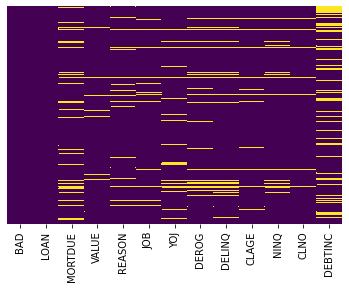

In [6]:
# Heatmap for null/missing values
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

Most of the data is already numerical, only two are of strings type (_REASON_ and _JOB_).

In [7]:
print(df["REASON"].value_counts())
print(df["JOB"].value_counts())

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64


**We need to fill these two variable's null values and OneHot Encode them to plot their distribution efficiently.<br><br>**
Reason/Meaning of null values in REASON and JOB, and how we will fill these:<br><br>

We can replace the missing value with 
* a new value _"Unknown"_ 
* values based on the distribution of non-missing values
* the most frequent value  
* the predicted value using other attributes and Decision Tree.
<br><br>
[//]: # (Hello)
REASON - This shows the reason why the person is taking the loan. There are two available values : Debt consolidation and Home Improvement. The missing value must be showing that the Reason of taking the loan was not either of the two given optins and hence was left empty. So, **filling the missing values with a new value _"Other reason"_, for this attribute**.<br><br>


JOB - This tells the occupation of the applicant. There are 6 unique values for this attribute, and the value _"Other"_ is the most frequent. The _"Other"_ value is already present, so it rules out the reasoning used above. Out of the remaining options, we can **replace the missing values with the most frequent value for simplicity**<br><br>

DEROG - Around 4700 have value _0_. So, **replacing the missing values with the mode** (i.e. 0) 
<br><br>
DELINQ - Around 5200 have same value (_0_). **Replacing the missing with the mode value**. 

In [8]:
# We can fill the missing values with the mode, i.e. "Other", or we can fill the missing values depending on the distribution of the non-null values. 
df["REASON"].fillna("Other reason",inplace=True)
df["JOB"].fillna(df["JOB"].mode()[0],inplace=True)
df["DEROG"].fillna(value=0,inplace=True)        # Filling the missing value with the mode
df["DELINQ"].fillna(value=0,inplace=True)       # Filling the missing value with the mode
# print(df["JOB"].isna().sum())

_REASON_ and _JOB_ are categorical attributes and of string type. Some plots work only with numerical values, so we need to convert them to numericals. Using Label Encoding on these two variables to convert them to numerical values. (We can also use One-Hot-Encoding)

In [9]:
label_encoder = preprocessing.LabelEncoder()
df['JOB']= label_encoder.fit_transform(df['JOB'])
df['REASON']= label_encoder.fit_transform(df['REASON'])

All the attributes are of numerical type,now, we can use plots to understand the distribution of all the the attributes.
<br><br>Plotting Boxplots for each attribute in df

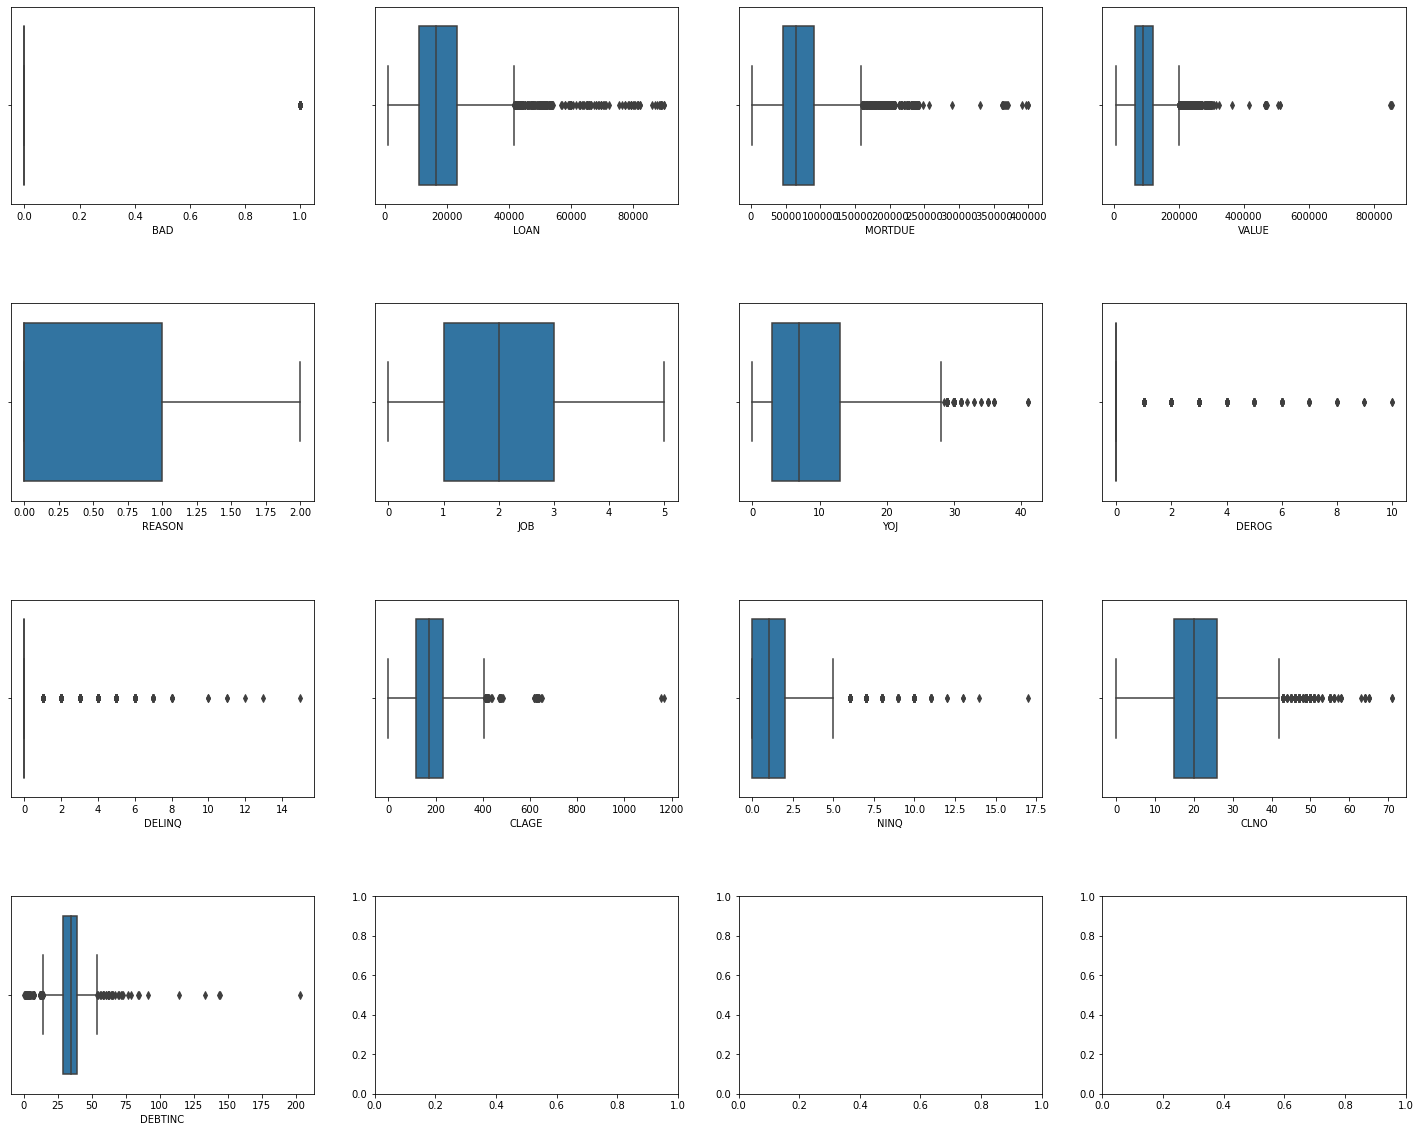

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(25, 20),)
for i,ax in zip(df.columns,axes.flat):
    sns.boxplot(data=df, x=i,ax=ax)     # we can also use violin plot 
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Plotting Histograms to see the distribution of each attribute

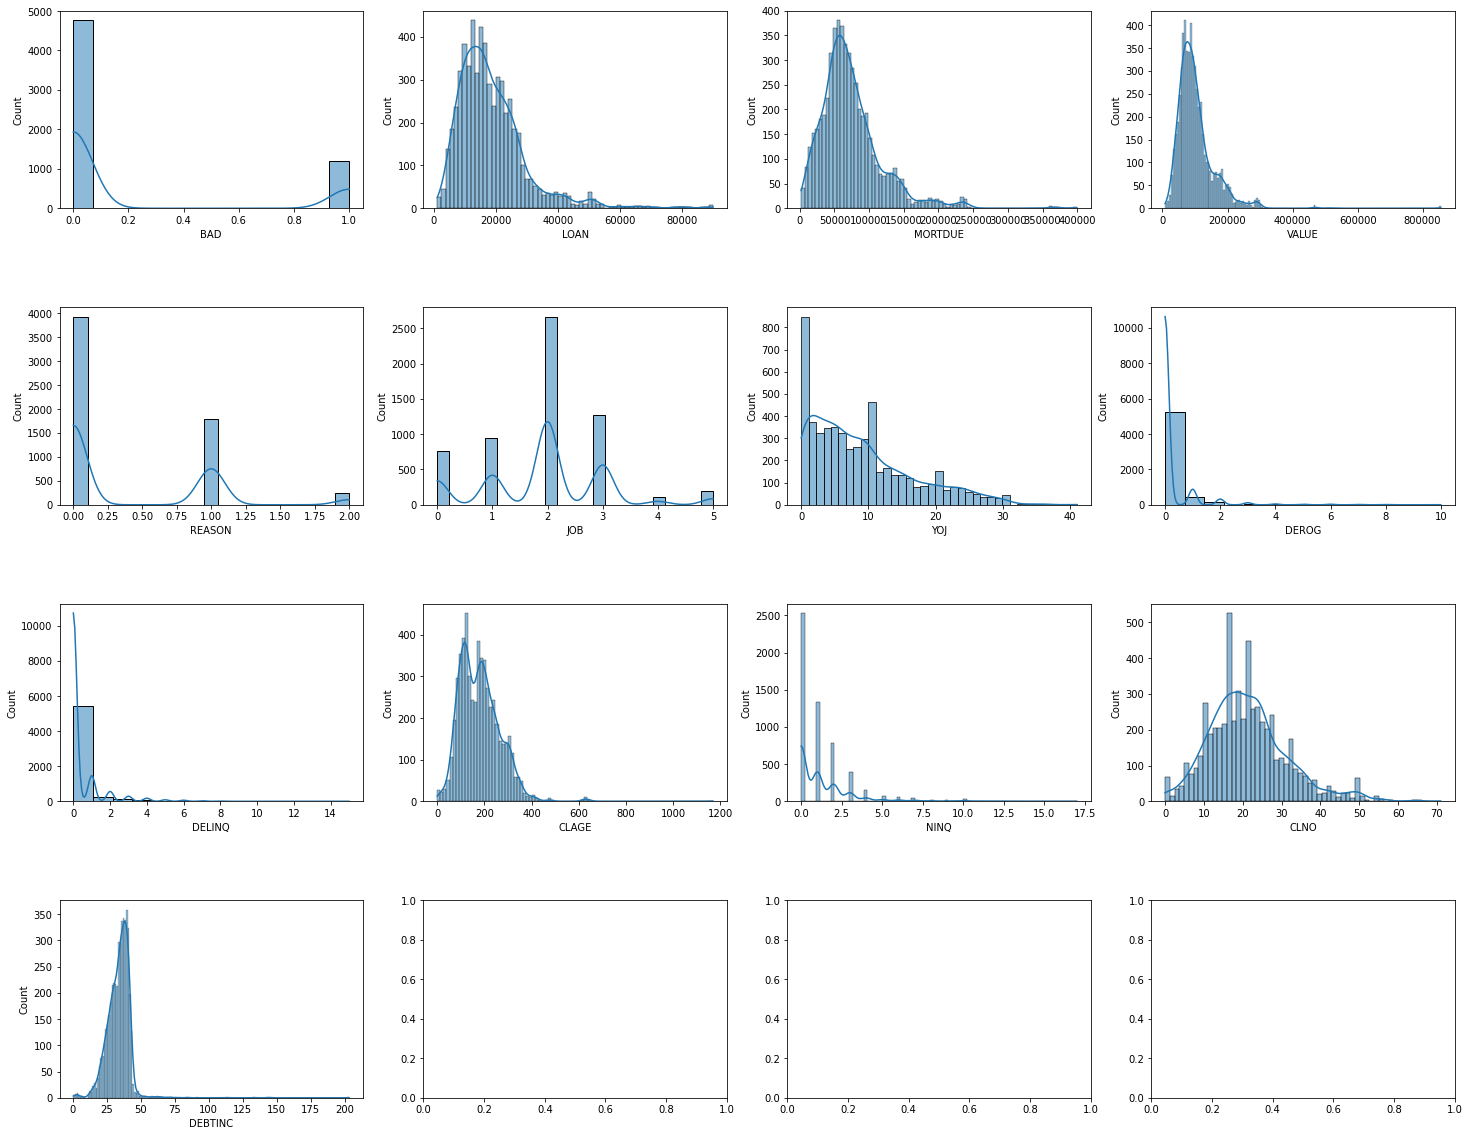

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(25, 20))
for i,ax in zip(df.columns,axes.flat):
    sns.histplot(data=df,x=i,ax=ax,kde=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


<Figure size 432x288 with 0 Axes>

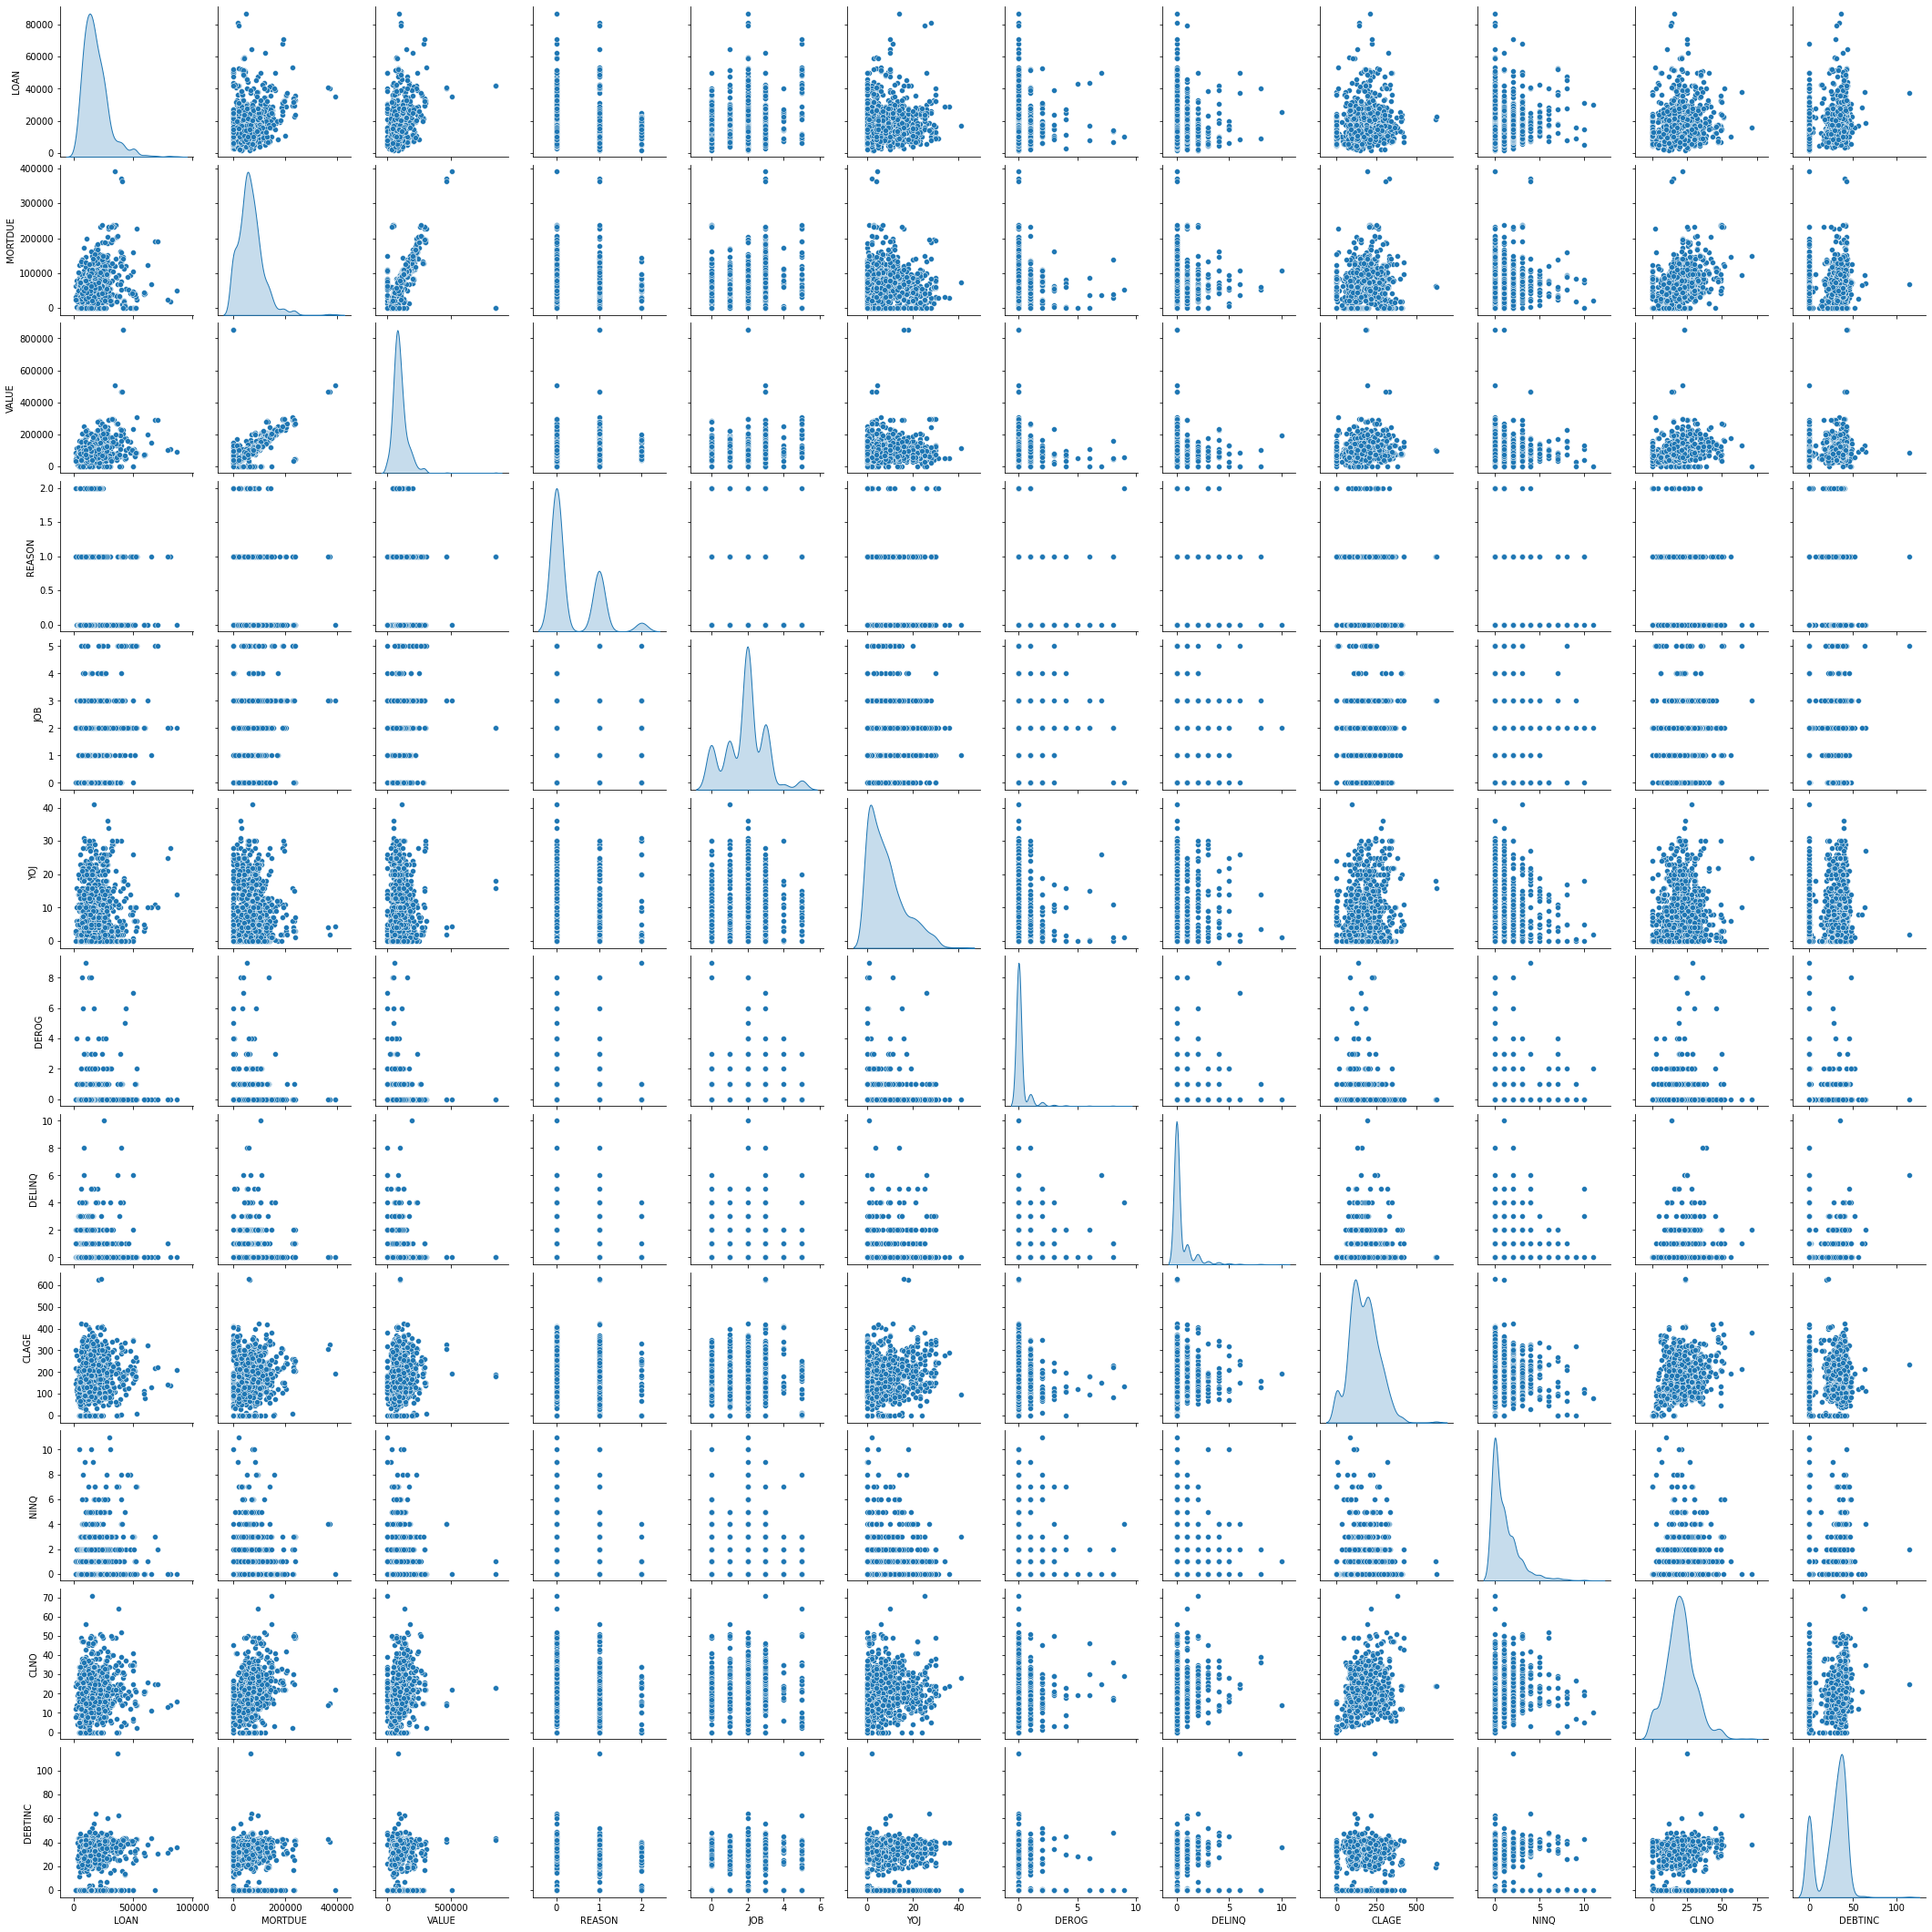

In [29]:
# Pair Plot, takes too much time, comme/nting for now
plt.figure()
# plt.pair
sns.pairplot(df.sample(1000),diag_kind='kde')
plt.show()
## Method - 2 ##
# from IPython.display import Image

# sns_plot = sns.pairplot(df, height=2.0)
# sns_plot.savefig("pairplot.png")

# plt.clf()
# Image(filename='pairplot.png') 

Observations from the above plots:
* The **scale of each attribute is different**, we need to normalize all the features. 
* Some attributes have **skewed distribution**
* Some attributes have a lot of **outliers** (DEBTINC, LOAN, MORTDUE, VALUE)
[//]: # (Hello)
For normalizing, we can use Min-Max Scaler, but attributes like LOAN, MORTDUE, VALUE have a lot of outliers (from boxplot), so we will also try Z-Score Normalization (preferred).
<br>
For fixing the skewness, we need to transform the attributes. 

**Numerosity Reduction** : Apart from the above needed steps, many tuple/observations might have many missing values in their attributes. We can consider dropping them to improve the data quality. For this we need to decide a threshold value, such that the data quality is also improved and a lot os data isn't lost.<br>
**Feature Reduction** - Dropping columns with same value for most of the observations (_DELINQ_ and _DEROG_), and after considering their Correlation and Predictive Power Score(_REASON_ and _JOB_). 

Plotting Heatmap of correlation Matrix, to understand the type of linear relation between attributes.<br>
We will again plot Heatmap of correlation after cleaning and transforming the attributes.<br>


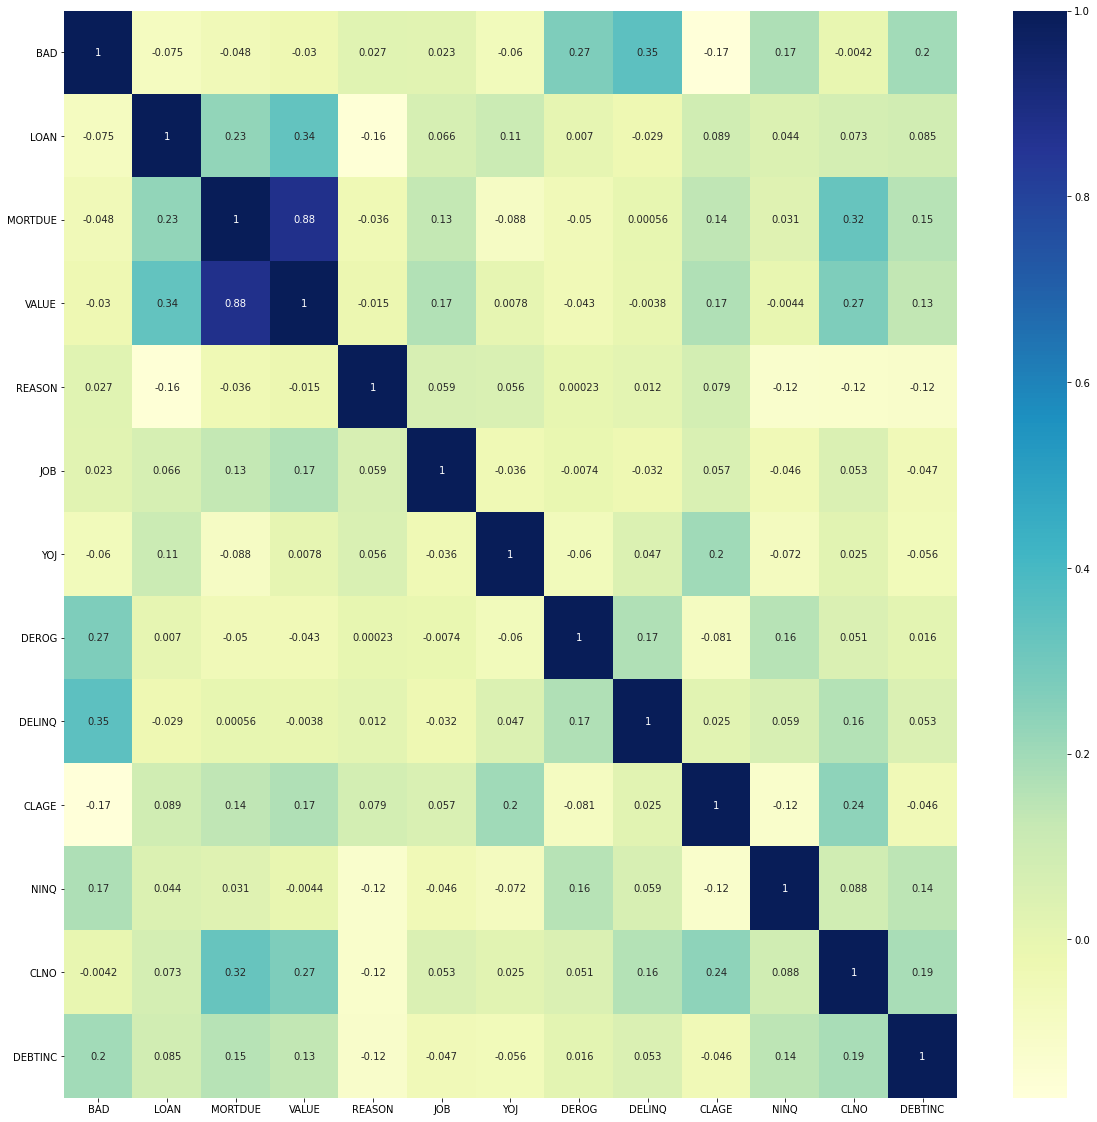

In [13]:
plt.figure(figsize=(20,20))
heat_map = sns.heatmap(df.corr(),cmap = "YlGnBu",annot=True)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
# sns.color_palette("mako", as_cmap=True)
plt.show()

## Data Cleaning and Transformation

In [ ]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

In [ ]:
df3=remove_outlier_IQR(df2)

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(25, 20),)
for i,ax in zip(df3.columns,axes.flat):
    sns.boxplot(data=df3, x=i,ax=ax)     # we can also use violin plot 
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

PCA can be performed for both the numeric continous variables and the categorical and numeric discrete variables but it is most effective and designed for numeric continous variables.

In [ ]:
df4 = df.select_dtypes(include=numerics)
df4.describe()
df4=df4.drop(columns=['DEROG','DELINQ'])
df4.dropna(axis=0,thresh=3,inplace=True)
df4.fillna(value=0,inplace=True)
from sklearn.preprocessing import StandardScaler
df4 = StandardScaler().fit_transform(df4)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df4)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [17]:
numerics = ['float64']
df1 = df.select_dtypes(include=numerics)
# Number of rows/tuples where more than 3 attributes are missing
sum((df.isna().sum(axis=1))>3)

167

We can consider those tuples where more than 4 attributes are missing

In [15]:
#first dropping datapoints which more than 4 rows missing considering 2 categorical variables have already been added
df.dropna(axis=0,thresh=4,inplace=True)   # Numerosity Reduction 

Filling the rest of the missing values using interpolation (can also use Decision Tree)

In [18]:
df.fillna(value=0,inplace=True)

In [19]:
df.fillna(value=df.mode(),inplace=True)

In [20]:
# Using Predictive Power Score to see whether the attributes are independently able to predict the defaulters
# df_pps = df.join(y)
# score = pps.matrix(df_pps)
# print(score[score['y']=='BAD'])

In [22]:
def pps(df,categorical_features=None,numerical_features=None):    # Predictive Power Score
    columns = ["Feature", "Target","PPS", "Type of Prediction", "Cross-Val Score", "Training Score","Naive-Baseline Score", "Model"]
    pps_df=pd.DataFrame(columns=columns)
    for i in df.columns:
        for j in df.columns:
            if(j in categorical_features or type(df[j])==str):
                model = DecisionTreeClassifier()
                lab_enc = preprocessing.LabelEncoder()
                label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),label_encoded_y)
                model.fit(x_train,y_train)
                y_pred=model.predict(x_test)
                f1 = metrics.f1_score(y_test,y_pred)
                mode = np.full((len(x_test),1),df[j].mode())
                f1_naive = metrics.f1_score(y_test,mode)
                pps_score=max(0,(f1-f1_naive)/(1 - f1_naive))
                cv_score=model.score(x_test,y_test)
                train_score=model.score(x_train,y_train)
                pps_df = pps_df.append({"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Classification","Cross-Val Score":cv_score,"Training Score":train_score,"Naive-Baseline Score":f1_naive,"Model":"DecisionTreeClassifier()"},ignore_index=True)
            else:
                model = DecisionTreeRegressor()
                # lab_enc = preprocessing.LabelEncoder()
                # label_encoded_y = np.array(lab_enc.fit_transform(df[j])).reshape(-1,1)
                x_train,x_test,y_train,y_test = train_test_split(np.array(df[i]).reshape(-1,1),np.array(df[j]).reshape(-1,1))
                model.fit(x_train,y_train)
                median = np.full((len(x_test),1),df[j].median())
                naive_mae = metrics.mean_absolute_error(y_test, median)
                y_pred=model.predict(x_test)
                mae=metrics.mean_absolute_error(y_test,y_pred)
                train_score=mean_absolute_error(y_train,model.predict(x_train))
                pps_score = max(0,1 - mae/naive_mae)
                pps_df=pps_df.append({"Feature":i,"Target":j,"PPS":pps_score,"Type of Prediction":"Regression","Cross-Val Score":mae,"Training Score":train_score,"Naive-Baseline Score":naive_mae,"Model":"DecisionTreeRegressor()"},ignore_index=True)
    
    return pps_df
categ = ["BAD"]
pps_f = pps(df,categ)

In [23]:
pps_f

,Feature,Target,PPS,Type of Prediction,Cross-Val Score,Training Score,Naive-Baseline Score,Model
0,BAD,BAD,1.000000,Classification,1.000000,1.000000,0.000000,DecisionTreeClassifier()
1,BAD,LOAN,0.000000,Regression,8122.399880,7842.513715,8048.590604,DecisionTreeRegressor()
2,BAD,MORTDUE,0.000000,Regression,33400.932917,34425.244247,33161.348644,DecisionTreeRegressor()
3,BAD,VALUE,0.000000,Regression,39827.107293,40255.031467,38760.048839,DecisionTreeRegressor()
4,BAD,REASON,0.000000,Regression,0.506368,0.502276,0.395973,DecisionTreeRegressor()
...,...,...,...,...,...,...,...,...
164,DEBTINC,DELINQ,0.000000,Regression,0.605710,0.251664,0.368456,DecisionTreeRegressor()
165,DEBTINC,CLAGE,0.000000,Regression,92.509953,14.872564,69.863959,DecisionTreeRegressor()
166,DEBTINC,NINQ,0.000000,Regression,1.375318,0.312208,1.138926,DecisionTreeRegressor()
167,DEBTINC,CLNO,0.000000,Regression,10.471106,1.916135,8.020805,DecisionTreeRegressor()


Building the Model

In [24]:
# Dividing the dataset into training and cross-validation
y = df["BAD"]
df.drop(["BAD"],axis=1,inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df,y)

Testing the models on cross-validation dataset, and comparing with training dataset

In [88]:
# Training Decision Tree Model
dtree = DecisionTreeClassifier(max_leaf_nodes=40,max_depth=8,criterion="gini")
dtree.fit(x_train,y_train)
print("Accuracy on Training Dataset : ",dtree.score(x_train,y_train))
print("Accuracy on CV Dataset : ",dtree.score(x_test,y_test))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=40,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [108]:
rforest = RandomForestClassifier(max_depth=7,max_leaf_nodes=40,n_estimators=100,n_jobs=-1)
rforest.fit(x_train,y_train)
print("Accuracy on Training Dataset : ",rforest.score(x_train,y_train))
print("Accuracy on CV Dataset : ",rforest.score(x_test,y_test))

Accuracy on Training Dataset :  0.9134228187919463
Accuracy on CV Dataset :  0.8986577181208054


In [135]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty="l1",solver="liblinear",max_iter=100,C=0.004)
lr.fit(x_train,y_train)
print("Accuracy on Training Dataset : ",lr.score(x_train,y_train))
print("Accuracy on CV Dataset : ",lr.score(x_test,y_test))

Accuracy on Training Dataset :  0.8619686800894855
Accuracy on CV Dataset :  0.8617449664429531


EXTRAs

((array([-3.68070914, -3.4480915 , -3.32001917, ...,  3.32001917,
          3.4480915 ,  3.68070914]),
  array([2.39979468, 2.45043349, 2.49466025, ..., 4.15714915, 4.16063427,
         4.16121314])),
 (0.2396664761022781, 3.358682923063093, 0.9978241586221487))

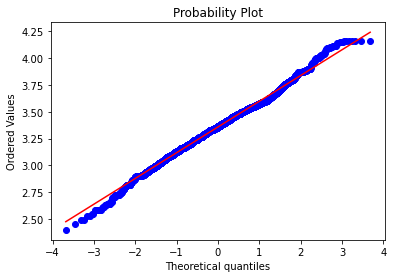

In [122]:
from scipy.stats import probplot, boxcox    # How data transformation helps changing the distribution to Gaussian
probplot(((df["LOAN"])**0.125),dist="norm",plot=plt)